In [2]:
import os
import torch
from torch import nn
from torch import optim
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle

In [3]:
class LidarBrain(nn.Module):
    
    def __init__(self, inputs_size, hidden1_size, hidden2_size, hidden3_size, outputs_size):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(inputs_size, hidden1_size),
            nn.Linear(hidden1_size, hidden2_size),
            nn.Linear(hidden2_size, hidden3_size),
            nn.Linear(hidden3_size, outputs_size)
        )

    def forward(self, x):

        return self.model(x)

In [4]:
load_path = "C:/Users/nilsm/workspace/MakeAIWork2/project/simpylc/data/data_2rounds"

data_file = pd.read_table(load_path, sep = ",", index_col = 0)


# Create X data and Y data by converting them to torch.tensor
X = torch.Tensor(np.array(data_file.iloc[:, :-2], copy=False))

# We decided to leave out the velocity for now.
Y = torch.Tensor(np.array(data_file.iloc[:, 16:17], copy=False))

print(X.type())
print(Y[0].type())

torch.FloatTensor
torch.FloatTensor


LidarBrain(
  (model): Sequential(
    (0): Linear(in_features=16, out_features=40, bias=True)
    (1): Linear(in_features=40, out_features=30, bias=True)
    (2): Linear(in_features=30, out_features=1, bias=True)
  )
)
[567963.2362129313, 522270.7913228342, 493361.9746959835, 477777.5392315649, 469220.8922288047, 463802.1851054568, 459889.31200485374, 456810.0762839238, 454262.23419427394, 452098.85094086285, 450242.8188827026, 448650.30774074094, 447293.31938899844, 446151.0073300962, 445205.62036668975, 444440.12563859636, 443837.5369296551, 443380.81944423326, 443053.12183265307, 442838.1051519631, 442720.3388939871, 442685.4972958627, 442720.84048065403, 442815.00727879704, 442957.9979132724, 443141.31194896647, 443357.66744203545, 443600.78775327234, 443865.42118235986, 444147.29953766085]


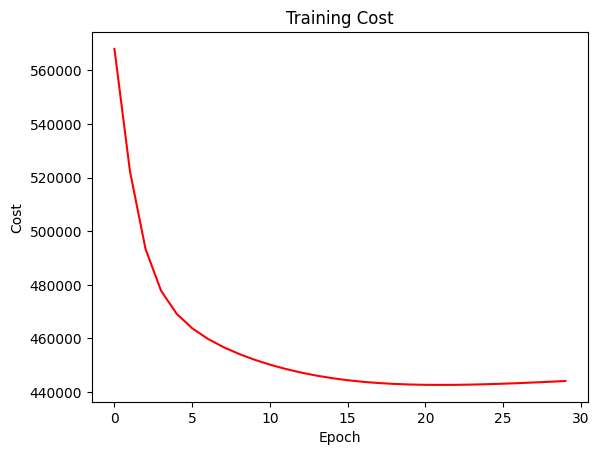

In [35]:
epochs = 30

learningRate = 0.000001

#----------------------------------------

lb = LidarBrain(16, 40, 40, 40, 1)

print(lb)

#----------------------------------------

losses = []

# Take binary cross entropy as loss function (one output interpreted as binary)
lossFunction = nn.MSELoss()

# Use stochastic gradient descent as optimizer, use weights and biases of model
gradientDescent = torch.optim.SGD(lb.parameters(), lr=learningRate)

#----------------------------------------

for i in range(epochs):

    losses_epoch = []
    for x, y in zip(X, Y):
    
        # Reset the gradient delta's (dw, db)
        gradientDescent.zero_grad()

        # Forward step
        yhat = lb(x)

        # Compute loss
        loss = lossFunction(yhat, y)
        
        # Keep track of loss
        losses_epoch.append(loss.item())

        # Apply gradient descent (via backpropagation)
        loss.backward()

        # Use w += -step * dw * learnRate
        gradientDescent.step()

    losses.append(sum(losses_epoch))

print(losses)

#----------------------------------------

fig, ax = plt.subplots()
ax.set(xlabel='Epoch', ylabel='Cost', title="Training Cost")

plt.plot([x for x in range(len(losses))], losses, 'red')
plt.show()

#----------------------------------------

In [34]:
save_path = "C:/Users/nilsm/workspace/MakeAIWork2/project/simpylc/pickle/LidarBrain.pkl"

pickle.dump(lb.model, open(save_path, 'wb'))

In [32]:
pkl_load_path = "C:/Users/nilsm/workspace/MakeAIWork2/project/simpylc/pickle/LidarBrain.pkl"
lb_model = pickle.load(open(pkl_load_path, "rb"))

lb_model

RuntimeError: Storage size calculation overflowed with sizes=[20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20]